
# **Initiate and Configure Spark**

---


In [ ]:
########## ONLY in Colab ##########
!pip3 install pyspark
########## ONLY in Colab ##########

     |████████████████████████████████| 281.4 MB 24 kB/s 
     |████████████████████████████████| 198 kB 41.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9915f316591404dc39d0b954b2521657e1dd84cc9e1f7de370bee900b04d576a
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# linking with SparkSession
from pyspark.sql import SparkSession
group_6_session = SparkSession.builder.master("local[*]").appName('Group 6').getOrCreate()


In [ ]:
########## ONLY in Colab ##########
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')
########## ONLY in Colab ##########

Mounted at /content/drive



# **Load Data**

---


In [ ]:
# Load Data from Colab:

########## ONLY in Colab ##########

main_df = group_6_session.read.option("header", "true").csv("/content/drive/MyDrive/UNSW-NB15.csv", inferSchema=True).toDF('srcip',
'sport',
'dstip',
'dsport',
'proto',
'state',
'dur',
'sbytes',
'dbytes',
'sttl',
'dttl',
'sloss',
'dloss',
'service',
'Sload',
'Dload',
'Spkts',
'Dpkts',
'swin',
'dwin',
'stcpb',
'dtcpb',
'smeansz',
'dmeansz',
'trans_depth',
'res_bdy_len',
'Sjit',
'Djit',
'Stime',
'Ltime',
'Sintpkt',
'Dintpkt',
'tcprtt',
'synack',
'ackdat',
'is_sm_ips_ports',
'ct_state_ttl',
'ct_flw_http_mthd',
'is_ftp_login',
'ct_ftp_cmd',
'ct_srv_src',
'ct_srv_dst',
'ct_dst_ltm',
'ct_src_ ltm',
'ct_src_dport_ltm',
'ct_dst_sport_ltm',
'ct_dst_src_ltm',
'attack_cat',
'Label')

In [ ]:
main_df.show()

# Data exploration

In [ ]:
#main_df.printSchema()

In [ ]:
print((main_df.count(), len(main_df.columns)))

In [ ]:
main_df.describe().show()

In [ ]:
from pyspark.sql.functions import col

print('List of columns with null values')

for cols in main_df.columns:
  value = main_df.filter(col(cols).isNull()).count()

  if value > 0:
    print(cols + ': ' + str(value))

## Handling duplicate rows

In [ ]:
import pyspark.sql.functions as funcs

main_df.groupBy(main_df.columns).count().where(funcs.col('count') > 1).select(funcs.sum('count')).show()

+----------+
|sum(count)|
+----------+
|    568825|
+----------+



In [ ]:
main_df = main_df.dropDuplicates(main_df.columns)

In [ ]:
import pyspark.sql.functions as funcs

main_df.groupBy(main_df.columns).count().where(funcs.col('count') > 1).select(funcs.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



## Find numeric and categorical column

In [ ]:
numeric_columns = list()
categorical_column = list()

for col_ in main_df.columns:
    if main_df.select(col_).dtypes[0][1] != "string":
        numeric_columns.append(col_)
    else:
        categorical_column.append(col_)
        
print("Numeric columns",numeric_columns)
print("categorical columns",categorical_column)

Numeric columns ['sport', 'dsport', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Label']
categorical columns ['srcip', 'dstip', 'proto', 'state', 'service', 'attack_cat']


## Visualizing distribution of each attack

In [ ]:
pd_df = main_df.select('attack_cat').toPandas()

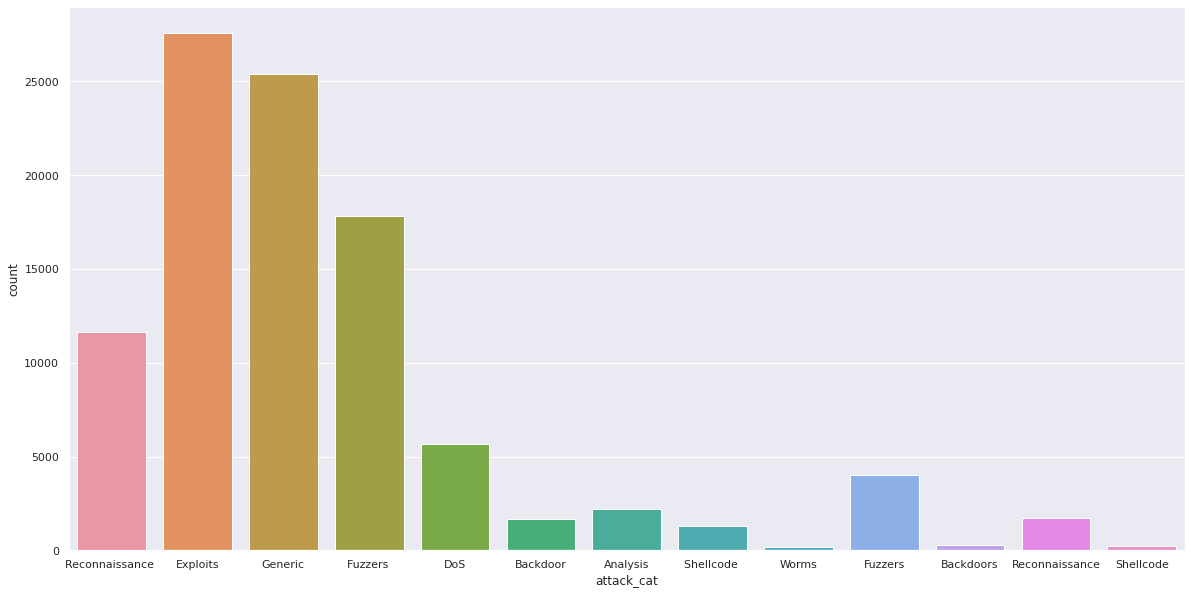

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20,10))

sns.set_theme(style="darkgrid")
ax = sns.countplot(x="attack_cat", data=pd_df)

# **Data pre-processing**

# Handling "null" in the  column "attack_cat"

In [ ]:
main_df.groupBy('Label').count().show()

+-----+-------+
|Label|  count|
+-----+-------+
|    1|  99643|
|    0|1959471|
+-----+-------+



In [ ]:
#Attack_cat has null values, but these "null" actually are "No attack recorded" and hence we replace the label
main_df.groupBy('attack_cat').count().show()

+---------------+-------+
|     attack_cat|  count|
+---------------+-------+
|          Worms|    171|
|      Shellcode|    223|
|           null|1959471|
|      Backdoors|    299|
|        Fuzzers|   3991|
|       Analysis|   2184|
|     Shellcode |   1288|
|            DoS|   5665|
|Reconnaissance |  11617|
| Reconnaissance|   1740|
|       Backdoor|   1684|
|       Fuzzers |  17804|
|       Exploits|  27599|
|        Generic|  25378|
+---------------+-------+



In [ ]:
main_df = main_df.na.fill(value='no_atttack',subset=["attack_cat"])

# String indexing the non-numeric features

In [ ]:
#main_df.printSchema()

In [ ]:
string_features = ["srcip","dstip","state","service","proto"]

In [ ]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder

In [ ]:
for col in string_features:
  suhail_stringindexer = StringIndexer(inputCol=col, outputCol="{0}_index".format(col)).fit(main_df)
  main_df = suhail_stringindexer.transform(main_df)

  encoder = OneHotEncoder(dropLast=False, inputCol="{0}_index".format(col), outputCol="{0}_vec".format(col)).fit(main_df)
  main_df = encoder.transform(main_df)

In [ ]:
new_main_df = main_df.drop(*['service', 'srcip', 'dstip','state','service_index','proto', 'srcip_index', 'dstip_index','state_index','proto_index'])

In [ ]:
cols = new_main_df.columns
cols.remove("Label")
cols.remove("attack_cat")

In [ ]:
print((new_main_df.count(), len(new_main_df.columns)))

(2059114, 49)


# Vector-assembling all the features

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=cols,outputCol="features")

final_df = assembler.transform(new_main_df)

In [ ]:
#final_df.select("features","Label").show(truncate=False)

# Standard-scaling the features

In [ ]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
final_df=standardscaler.fit(final_df).transform(final_df)

In [ ]:
final_df.select("Scaled_features","Label").show(truncate=False)

In [ ]:
#Train, test split
train, test = final_df.randomSplit([0.8, 0.2], seed=12345)

# Checking for imbalance in the data

In [ ]:
dataset_size=float(train.select("Label").count())

numPositives = train.select("Label").where('Label == 1').count()

per_ones=(float(numPositives)/float(dataset_size))*100

numNegatives=float(dataset_size-numPositives)


In [ ]:
print('Percentage of Attacks are {}'.format(per_ones))
print('Percentage of non-attacks are {}'.format(100-per_ones))

Percentage of Attacks are 4.837840560309622
Percentage of non-attacks are 95.16215943969038


In [ ]:
train_pd_df = main_df.select('Label').toPandas()



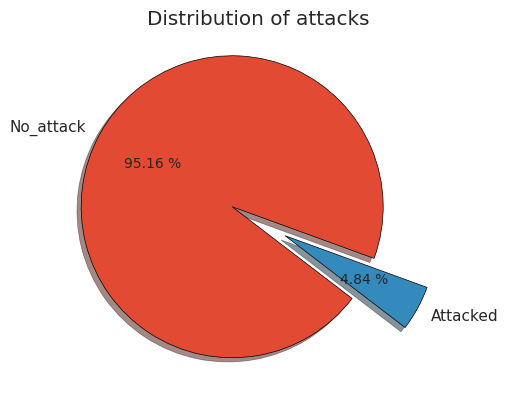

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5), dpi=100)
plt.style.use('ggplot')

explode = (.2, .2)   

plt.pie(train_pd_df['Label'].value_counts(), explode=explode, pctdistance=0.6,autopct='%.2f %%',labels = ['No_attack','Attacked'], shadow=True,startangle=340,wedgeprops={'edgecolor':'black'})

plt.title('Distribution of attacks')

plt.show()

In [ ]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.9516215943969037


In [ ]:
from pyspark.sql.functions import when

train = train.withColumn("classWeights", when(train.Label == 1,BalancingRatio).otherwise(1-BalancingRatio))


In [ ]:
#train.select("Scaled_features", "Label","classWeights").show(truncate=False)

## User-defined/helper functions

In [ ]:
#function for evaluating accuracy 


from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def accuracy_eval(predictions):
  eval = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")

  results = eval.evaluate(predictions)

  print(f'Accuracy is {round((results*100),2)}% ')

In [ ]:
#function to plot confusion matrix


import numpy as np
import seaborn as sns

def plt_cm(cm):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    return labels

In [ ]:
#function for classification report and confusion matrix


fn_list = list()
tp_list = list()

from sklearn.metrics import classification_report, confusion_matrix
def cr_and_cm(predictions):
  y_true_values = predictions.select(['Label']).collect()
  y_pred_values = predictions.select(['prediction']).collect()

  cr = classification_report(y_true_values, y_pred_values)
  print(cr)

  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true_values, y_pred_values)

  fn_list.append(cm[1][0])
  tp_list.append(cm[1][1])

  plt.figure(figsize = (10,8))

  labels = plt_cm(cm)
  sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 18})


# **Task 1 - Binary Classifier [20 marks]**

---


## ***Logistic Regression***
-------

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr_clf = LogisticRegression(labelCol="Label", featuresCol="Scaled_features", weightCol = "classWeights")

model = lr_clf.fit(train)

lr_predictions = model.transform(test)

In [ ]:
from os import truncate
lr_predictions.select("Label","prediction").show()

+-----+----------+
|Label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



## Evaluation of Logistic regression

In [ ]:
accuracy_eval(lr_predictions)

Accuracy is 98.61% 


In [ ]:
#Evaluating the model using ROC curve



from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Label")
auroc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc))

lr_predictions.select("Label","prediction","probability").show(15)


Area under ROC Curve: 0.9924
+-----+----------+-----------+
|Label|prediction|probability|
+-----+----------+-----------+
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
+-----+----------+-----------+
only showing top 15 rows



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


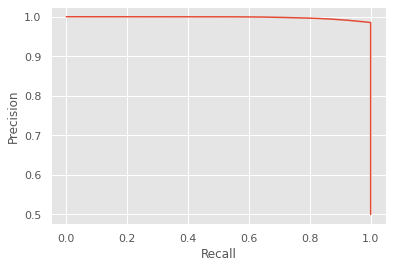

Model Accuracy 0.9924013425571316
FP rate [0.0002759485732204722, 0.014921366312501926]
TP rate [0.9850786336874982, 0.9997240514267796]


In [ ]:
#Model summary 



import matplotlib.pyplot as plt
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print("Model Accuracy",model.summary.accuracy)
print("FP rate",model.summary.falsePositiveRateByLabel)
print("TP rate",model.summary.truePositiveRateByLabel)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    391250
           1       0.78      1.00      0.87     19918

    accuracy                           0.99    411168
   macro avg       0.89      0.99      0.93    411168
weighted avg       0.99      0.99      0.99    411168



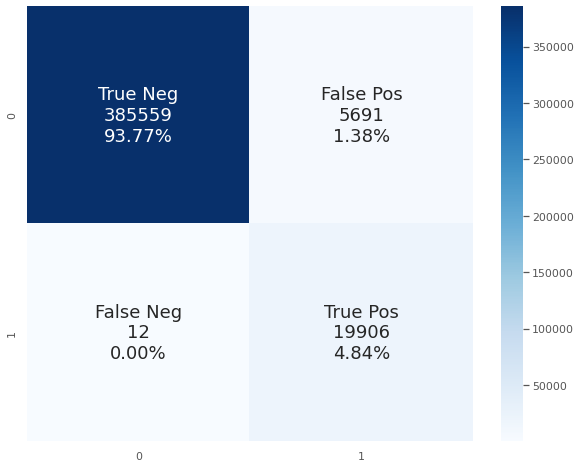

In [ ]:
cr_and_cm(lr_predictions)

---
## ***Gradient-boosted tree classifier***
---

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(labelCol="Label", featuresCol="Scaled_features", weightCol = "classWeights")

model = dt_clf.fit(train)

dt_predictions = model.transform(test)

## Evaluation of Decision tree classfifier

In [ ]:
accuracy_eval(dt_predictions)

Accuracy is 98.59% 


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    391250
           1       0.77      1.00      0.87     19918

    accuracy                           0.99    411168
   macro avg       0.89      0.99      0.93    411168
weighted avg       0.99      0.99      0.99    411168



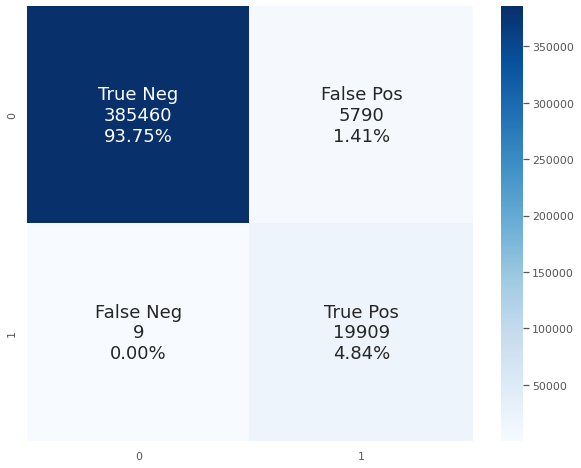

In [ ]:
cr_and_cm(dt_predictions)

---
## ***Naive Bayes classfier***
---

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="Label", featuresCol="Scaled_features", weightCol = "classWeights", smoothing=1.0, modelType="multinomial")
model = nb.fit(train)
nb_predictions = model.transform(test)

In [ ]:
accuracy_eval(nb_predictions)

Accuracy is 98.18% 


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    391250
           1       0.73      1.00      0.84     19918

    accuracy                           0.98    411168
   macro avg       0.86      0.99      0.92    411168
weighted avg       0.99      0.98      0.98    411168



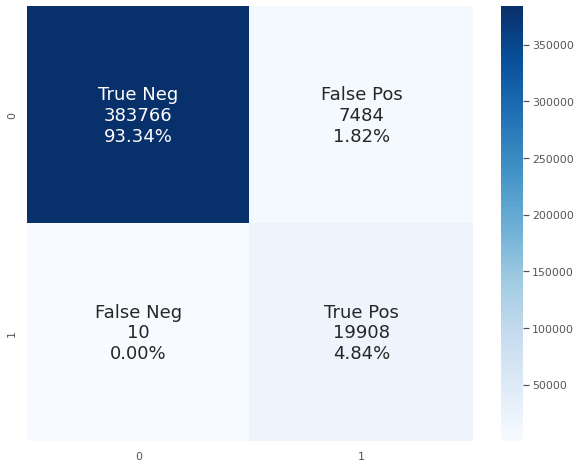

In [ ]:
cr_and_cm(nb_predictions)


# **Task 2 - Multi Classifier [25 marks]**

---


In [ ]:
# Machine Learning Technique, configuration, etc.:
# Place your notes here. 



In [ ]:
#string indexing the "attack_cat" column
stringindexer = StringIndexer(inputCol="attack_cat", outputCol="attack_index" ).fit(new_main_df)
main_df = stringindexer.transform(new_main_df)


In [ ]:
cols = main_df.columns
cols.remove("Label")
cols.remove("attack_cat")
cols.remove("attack_index")

# Vector-assembling all the features

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=cols,outputCol="features")

final_df = assembler.transform(main_df)

In [ ]:
final_df.select("features","attack_index").show()

+--------------------+------------+
|            features|attack_index|
+--------------------+------------+
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
+--------------------+------------+
only showing top 20 rows



# Standard-scaling the features

In [ ]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
scaled_final_df=standardscaler.fit(final_df).transform(final_df)

In [ ]:
scaled_final_df.select("Scaled_features","attack_index").show()

+--------------------+------------+
|     Scaled_features|attack_index|
+--------------------+------------+
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
|(295,[0,1,2,3,4,5...|         0.0|
+--------------------+------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType,FloatType

scaled_final_df = scaled_final_df.withColumn("attack_index",col("attack_index").cast(FloatType())) 

In [ ]:
(training, testing) = scaled_final_df.randomSplit([0.7, 0.3])

# Model building

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(labelCol="attack_index", featuresCol="Scaled_features", numTrees=8)

In [ ]:
rf_model = rf_classifier.fit(training)
rf_predictions = rf_model.transform(testing)

In [ ]:
back_converter = IndexToString(inputCol="prediction", outputCol="predicted_attack", labels=stringindexer.labels)
final_predictions = back_converter.transform(rf_predictions).select('Scaled_features','attack_index','predicted_attack','prediction')


In [ ]:
final_predictions.show()

+--------------------+------------+----------------+----------+
|     Scaled_features|attack_index|predicted_attack|prediction|
+--------------------+------------+----------------+----------+
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|      no_atttack|       0.0|
|(295,[3,11,17,23,...|         0.0|     

# Evaluation of Multi-class classfier

In [ ]:
#Accuracy

multi_class_model = MulticlassClassificationEvaluator(labelCol="attack_index", predictionCol="prediction", metricName="accuracy")

accuracy = multi_class_model.evaluate(final_predictions)

print(f'Accuracy is {round((accuracy*100),2)}% with test error {round((1 - accuracy)*100,2)}%')

Accuracy is 97.07% with test error 2.93%


In [ ]:
y_true_values = final_predictions.select(['attack_index']).collect()
y_pred_values = final_predictions.select(['prediction']).collect()

In [ ]:
#Classification report

from sklearn.metrics import classification_report, confusion_matrix
cm = classification_report(y_true_values, y_pred_values)
print(cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    586586
         1.0       0.69      0.62      0.65      8386
         2.0       0.97      0.79      0.87      7596
         3.0       0.00      0.00      0.00      5375
         4.0       0.85      0.33      0.48      3474
         5.0       0.00      0.00      0.00      1689
         6.0       0.00      0.00      0.00      1211
         7.0       0.00      0.00      0.00       652
         8.0       0.00      0.00      0.00       520
         9.0       0.00      0.00      0.00       476
        10.0       0.00      0.00      0.00       400
        11.0       0.00      0.00      0.00        81
        12.0       0.00      0.00      0.00        67
        13.0       0.00      0.00      0.00        55

    accuracy                           0.97    616568
   macro avg       0.25      0.20      0.21    616568
weighted avg       0.95      0.97      0.96    616568



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



# **Task 3 - Performance Measurements [15 marks]**

---


## Comparing the results of binary classifiers
---

In [ ]:
labels = ['Log.Reg-'+str(tp_list[0]), 'Dcsn tree-'+str(tp_list[1]), 'Naive Bay.-'+str(tp_list[2])]

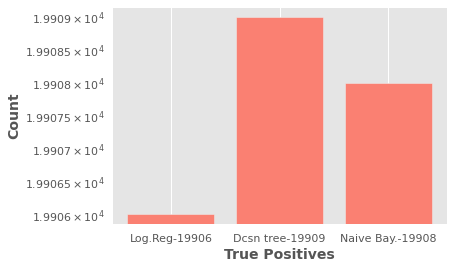

In [ ]:
plt.style.use('ggplot')
plt.bar(labels, tp_list, color='salmon',log=True)
plt.ylabel('Count',fontweight='bold',fontsize=14.0)
plt.xlabel('True Positives',fontweight='bold',fontsize=14.0)
plt.show()

In [ ]:
labels2 =  ['Log.Reg-'+str(fn_list[0]), 'Dcsn tree-'+str(fn_list[1]), 'Naive Bay.-'+str(fn_list[2])]

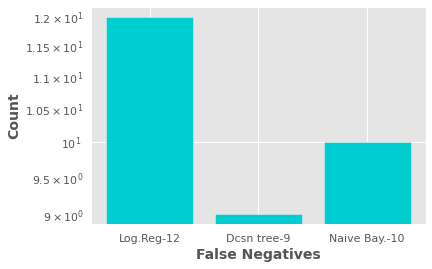

In [ ]:
plt.style.use('ggplot')
plt.bar(labels2, fn_list, color='darkturquoise',log=True)
plt.ylabel('Count',fontweight='bold',fontsize=14.0)
plt.xlabel('False Negatives',fontweight='bold',fontsize=14.0)
plt.show()

# **Convert ipynb to HTML for Turnitin submission**

---



In [ ]:
# install nbconvert (if facing with conversion error)
!pip3 install nbconvert 

In [ ]:
%%shell
jupyter nbconvert --to html //content/Group_6_ML.ipynb

[NbConvertApp] Converting notebook //content/Group_6_ML.ipynb to html
[NbConvertApp] Writing 594784 bytes to //content/Group_6_ML.html
